#Inference and Conclusions from AB Testing


#1. A/B Testing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets_TK530/I-6_Data.csv')
sum_stats = df.describe(include='all')
print(sum_stats)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Datasets_TK530/I-6_Data.csv'

In [ ]:
#Spend summary stats don't look right.  Looks like we need to clean up the $ and ' symbols.
df['Spend'] = df['Spend'].replace('[\$,]', '', regex=True).astype(float)

## Problem 1.1

The null hypothesis is that Treatment A has no effect on total spending. Or, that the mean spending is equal for Control and Treatment A populations.

##Problem 1.2

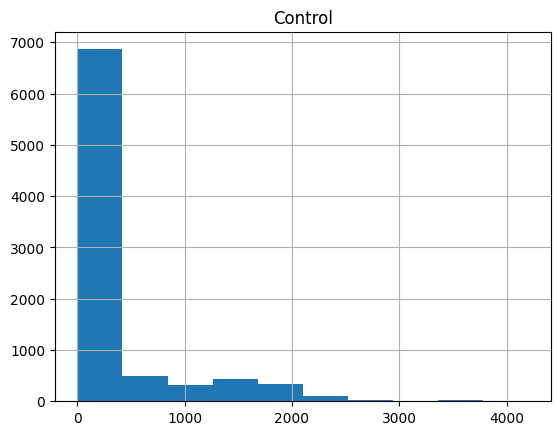

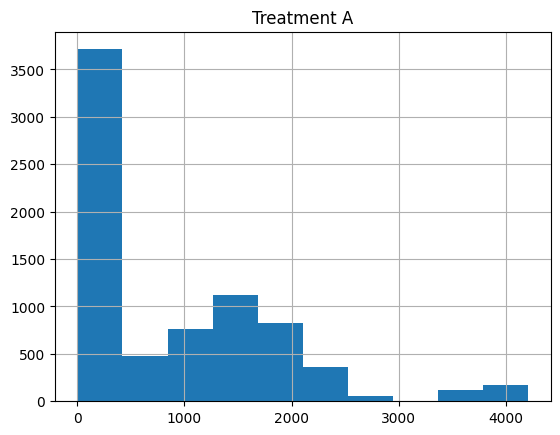

In [ ]:
for treatment, group_data in df.groupby('Treatment'):
    group_data.hist(column='Spend')
    plt.title(f'{treatment}')
    plt.show()

##Problem 1.3

In [ ]:
#To evaluate the A/B test, we should use the t-test to evaluate the statistical significance of the difference of the two means of the two treatments.

control = df.loc[(df['Treatment'] == 'Control'),'Spend'].dropna()
trtA = df.loc[(df['Treatment'] == 'Treatment A'),'Spend'].dropna()

#First, we want to evaluate variance equality to determine which t-test to run.
res = stats.levene(control, trtA)
res.pvalue

0.0

In [ ]:
#That indicates a difference in variances across the two samples, which tells us we should use the Welch's t-test.
t_stat, p_value = stats.ttest_ind(control, trtA, equal_var=False)

print(f"\nT-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3e}")


T-statistic: -42.294
P-value: 0.000e+00


##Problem 1.4

Our A/B testing shows that the new experimental design has a statistically significant effect on how much consumers decide to spend (in a positive direction). In fact, the change is so noticeable over our large sample size that we are nearly certain that the difference exists.

##Problem 1.5

The null hypothesis is that Treatment A has no effect on the conversion rate. Or, that the conversion rate is equal for Control and Treatment A populations.

##Problem 1.6

In [ ]:
'''I assume in this scenario, I would have the historical base conversion rate; since that isn't provided, I will
use the control conversion rate as an estimated baseline'''

In [ ]:
trtA_c = df.loc[(df['Treatment'] == 'Treatment A'),'Convert'].dropna()
conv_A = trtA_c.mean()
print(conv_A)

0.2524964336661912


I used this tool: https://www.statsig.com/calculator
For my calculation, I used:

*   α = 0.05
*   β = 0.2
*   Hypothesis testing = two-sided
*   MDE = 30% from baseline = 7.5 percentage points

The result that the sample size required was 19,000.



##Problem 1.7

In [ ]:
conv_rt = df.groupby('Treatment', as_index=False)['Convert'].mean()
conv_rt.head()

,Treatment,Convert
0,Control,0.261094
1,Treatment A,0.252496


##Problem 1.8

In [ ]:
import statsmodels.stats.proportion as smprop


n_control = (df['Treatment'] == 'Control').sum()
n_A = (df['Treatment'] == 'Treatment A').sum()

s_control = ((df['Treatment'] == 'Control') & (df['Convert'] == True)).sum()
s_A = ((df['Treatment'] == 'Treatment A') & (df['Convert'] == True)).sum()

In [ ]:
count = np.array([s_control, s_A])
nobs = np.array([n_control, n_A])

z_stat, p_value = smprop.proportions_ztest(count, nobs)
print(f"Z-statistic: {z_stat}, P-value: {p_value}")

Z-statistic: 1.2585502056656586, P-value: 0.2081928422259185


##Problem 1.9

The results of the A/B test tells us that we cannot confidently say that our experimental design had an effect on conversion rates. Because of the small change in conversion rates, even given the large sample size, there is about a one-in-five chance that this observed difference is completely random.  The confidence level we set (95%), an industry best practice, is our expectation of the probability that this difference is NOT attributed to error/randomness. Hence, since the probability of randomness defining the difference is 20%, it does not meet our comfort threshold, which would be 100%-95% = 5%. Conversely, we set our power of our test to be 80%, which means refers to the likelihood that our measurement is a false negative. This is set at a lower level, as false negatives are less harmful.

#2. Connecting to Business Objectives

##Problem 2.1

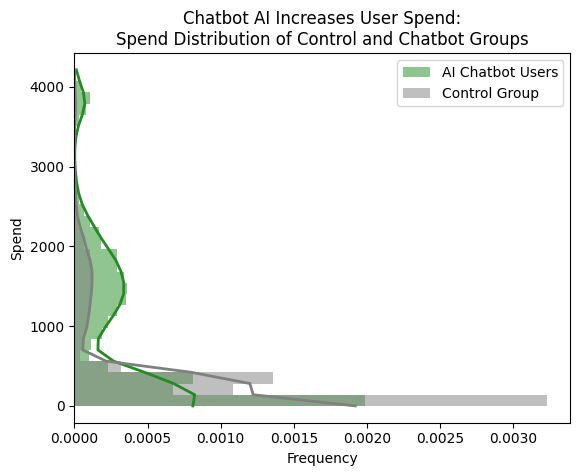

In [ ]:
from scipy.stats import gaussian_kde

spend_A = df[df['Treatment']== 'Treatment A']['Spend']
spend_C = df[df['Treatment']== 'Control']['Spend']
fig, ax = plt.subplots()
_, bins, _ = ax.hist(spend_A, bins=30, alpha=0.5, density=True, color = 'forestgreen', orientation = 'horizontal', label = 'AI Chatbot Users')
ax.hist(spend_C, bins=bins, alpha=0.5, density=True, orientation = 'horizontal',color = 'grey',label = 'Control Group')

kde_A = gaussian_kde(spend_A.dropna())
kde_A_vals = kde_A(bins)
ax.plot(kde_A_vals, bins, color='forestgreen', lw=2)

kde_C = gaussian_kde(spend_C.dropna())
kde_C_vals = kde_C(bins)
ax.plot(kde_C_vals, bins, color='grey', lw=2)

ax.set_xlabel('Frequency')
ax.set_ylabel('Spend')
ax.set_title('''Updated AI Chatbot Increases User Spend:
Spend Distribution of Control and Chatbot Groups''')
ax.legend()

plt.show()

**Key Takeaways**

Our preliminary analyses show that there was a statistically significant change in spend with the AI Chatbot, but not a stastically significant change in conversion. With this information, we might infer that customers are more likely to plan pricier trips when interacting with the chatbot, but are not more likely to decide on whether to finish the transaction. See the above trendlines for how the distribution of spend differed between the control and chatbot groups.


**Business Implications**

We can increase revenue by deploying this chatbot. However, we need to do more to understand why users are are spending more — are they being pushed more expensive options when cheaper ones exist, or is it that they're aspiring to more lavish and rewarding adventures?  These are important questions to investigate as they can significantly impact our long-term trust and brand reputation with our clients.

**Follow-on Research Goals**

Addition questions we may seek to answer include:
*  Is there a difference in user satisfaction between control and treatment groups?
*  What changes in behavior — travel modality, lodging, destinations — are treatment groups exhibiting?
*  How are interactions prompting users to spend more?

##Problem 2.2(a) - Additional Data Analysis

*   List item
*   List item



In [ ]:
#Before starting, evaluating if treatment changed flight purchase likelihood
mod_dist = df.groupby('Treatment', as_index=False)[['Flight Purchase','Hotel Booking','Car Rental']].mean()
mod_dist.head()

,Treatment,Flight Purchase,Hotel Booking,Car Rental
0,Control,0.487903,0.113634,0.055384
1,Treatment A,0.482039,0.338737,0.230969


In [ ]:
#Seeing if flight spend increases based on treatment
fl_cont = df.loc[(df['Treatment'] == 'Control') & (df['Flight Purchase'] == True) ,'Spend'].dropna()
fl_A = df.loc[(df['Treatment'] == 'Treatment A')& (df['Flight Purchase'] == True),'Spend'].dropna()

fl_contm = fl_cont.mean()
fl_Am = fl_A.mean()

t_stat, p_value = stats.ttest_ind(fl_cont, fl_A, equal_var=False)

print(f"\nT-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3e}")
print(f"Flight Spend Mean - Control: {fl_contm}")
print(f"Flight Spend Mean - Treatment: {fl_Am}")


T-statistic: -29.683
P-value: 1.647e-179
Flight Spend Mean - Control: 511.14039990478454
Flight Spend Mean - Treatment: 1085.9443549265106


In [ ]:
fl_cont.head()

,Spend
3,280.37
6,80.02
9,291.75
11,196.05
15,1940.39


In [ ]:
#Seeing if flight conversion increases based on treatment

f_dat = df.loc[(df['Flight Purchase'] == True)].dropna()

f_n_c = (f_dat['Treatment'] == 'Control').sum()
f_n_a = (f_dat['Treatment'] == 'Treatment A').sum()

f_s_c = ((f_dat['Treatment'] == 'Control') & (df['Convert'] == True)).sum()
f_s_a = ((f_dat['Treatment'] == 'Treatment A') & (df['Convert'] == True)).sum()

count_f = np.array([f_s_c, f_s_a])
nobs_f = np.array([f_n_c, f_n_a])

z_stat, p_value = smprop.proportions_ztest(count_f, nobs_f)
print(f"Z-statistic: {z_stat}, P-value: {p_value}")

Z-statistic: 0.9867648424154145, P-value: 0.32375793382767715


##Problem 2.2(b) - Partnership Report

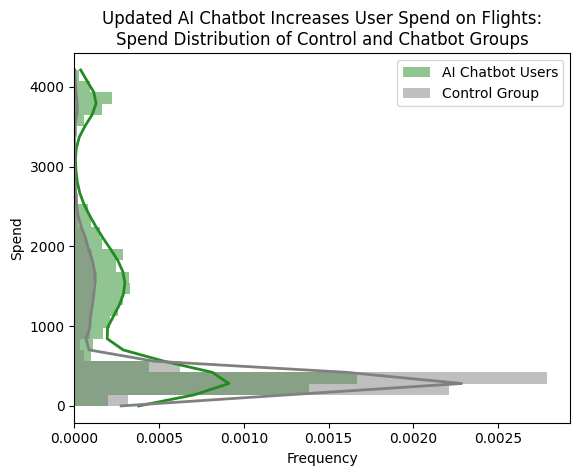

In [ ]:
spend_A = f_dat[f_dat['Treatment']== 'Treatment A']['Spend']
spend_C = f_dat[f_dat['Treatment']== 'Control']['Spend']
fig, ax = plt.subplots()
_, bins, _ = ax.hist(spend_A, bins=30, alpha=0.5, density=True, color = 'forestgreen', orientation = 'horizontal', label = 'AI Chatbot Users')
ax.hist(spend_C, bins=bins, alpha=0.5, density=True, orientation = 'horizontal',color = 'grey',label = 'Control Group')

kde_A = gaussian_kde(spend_A.dropna())
kde_A_vals = kde_A(bins)
ax.plot(kde_A_vals, bins, color='forestgreen', lw=2)

kde_C = gaussian_kde(spend_C.dropna())
kde_C_vals = kde_C(bins)
ax.plot(kde_C_vals, bins, color='grey', lw=2)

ax.set_xlabel('Frequency')
ax.set_ylabel('Spend')
ax.set_title('''Updated AI Chatbot Increases User Spend on Flights:
Spend Distribution of Control and Chatbot Groups''')
ax.legend()


**Key Takeaways**

Our preliminary analyses show that there was a statistically significant shift in flight spend for users interacting AI Chatbot, but not a stastically significant change in conversion. With this information, we might infer that customers are more likely to plan pricier flights when interacting with the chatbot, but are not more likely to decide on whether to finish the transaction. See the above trendlines for how the distribution of spend differed between the control and chatbot groups.


**Business Implications**

We are still learning more about user behavior in response to the model, but a likely short-term effect is an increase in revenue for TRIA after this model is deployed. We might infer that the model may influence consumers to pay more for accomondations like a better time for flights, better seats, etc.

**Action Items**

*  We would still like to do a bit more research into the specific mechanism that is increasing flight spend.  It would be helpful for TRIA to see if customers are consistently satisfied with their purchase, and got good value out of their ticket and experience.
*  If this is the case, TRIA may benefit from branching "up-market."
*  We also believe that we could better analyze the effect if TRIA could share with us the data of users who booked tickets via Reimagine Travel. This would allow us to better make sense of user behavior to ensure that TRIA continues to benefit from the partnership.